In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
import h5py
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift
import numba
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from utils.utils_torch import get_fourier_coord
from utils.simulations import center, wavefront_real, PSF
from kwave.utils import *
from kwave.ktransducer import *
from models.WienerNet import Wiener, WienerNet

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Load in Brain Data

(512, 2000)


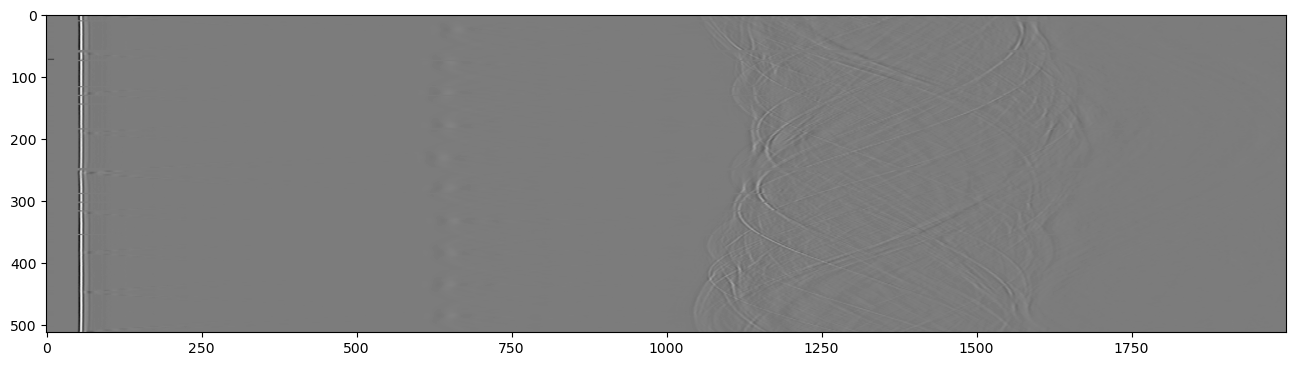

In [2]:
data = h5py.File('data/ANIMAL_LAYER.mat')
sinogram = np.array(data['Sinogram'])
print(sinogram.shape)
plt.subplots(figsize=(16,5))
plt.imshow(sinogram, cmap='gray')
plt.show()

(1, 2000)


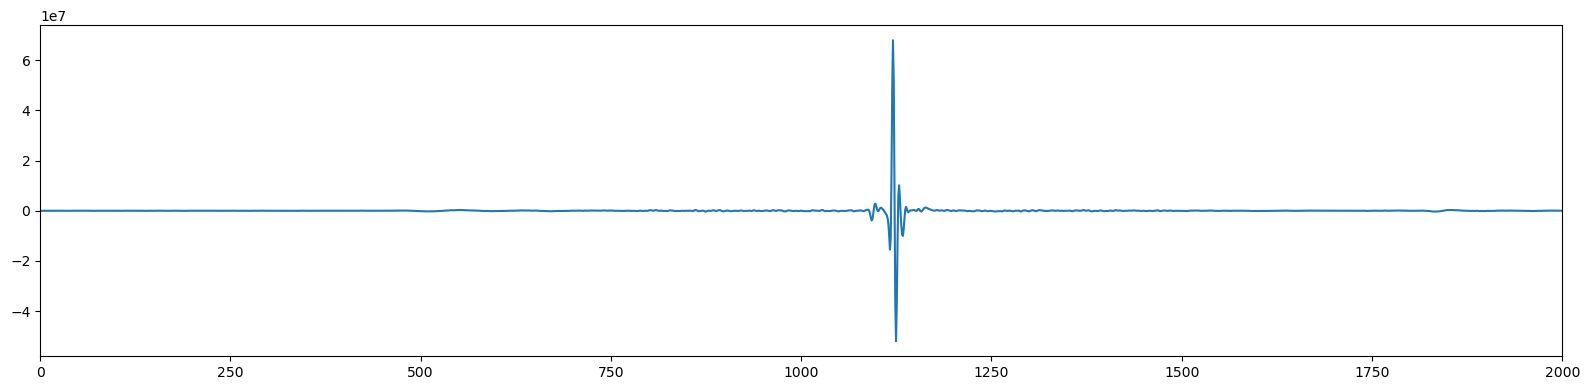

In [3]:
EIR_data = h5py.File('data/EIR_TUNGSTEN.mat')
EIR = np.array(EIR_data['EIR_AVE_20180516_LEFT'])
print(EIR.shape)

time = np.linspace(0, 2000, 2000)
plt.figure(figsize=(16,4))
plt.plot(time, np.squeeze(EIR[:2000]))
plt.xlim(0, 2000)
plt.tight_layout()

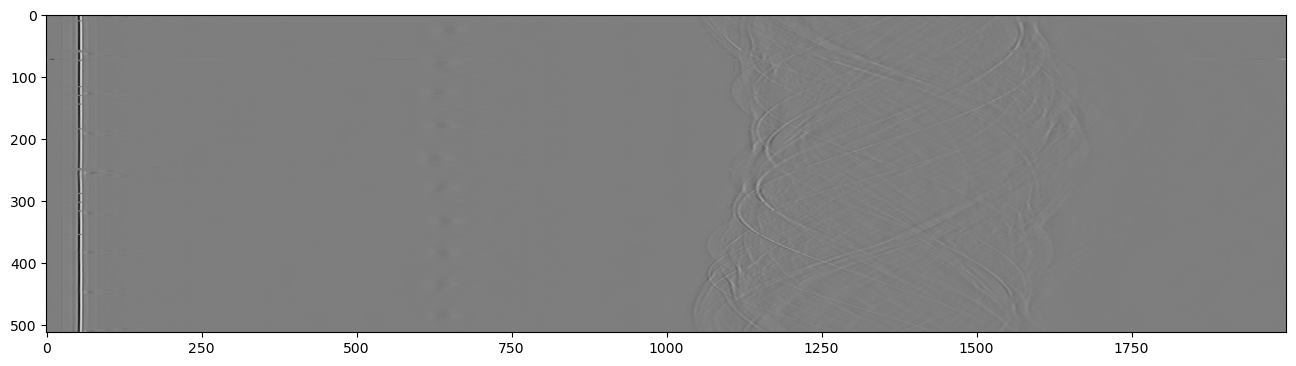

In [4]:
def deconvolve_sinogram(sinogram, EIR, t0):
    """Correct EIR phase of the sinogram.

    Args:
        sinogram (`numpy.array`): _description_
        EIR (`numpy.array`): EIR of the transducer.
        t0 (`int`): Time index of the EIR peak.

    Returns:
        `numpy.array`: The corrected sinogrm.
    """
    delta = np.zeros_like(EIR)
    delta[0, t0] = 1
    delta_ft = fft(delta, axis=1)
    EIR_ft = fft(EIR, axis=1)
    Sinogram_ft = fft(sinogram, axis=1)
    Sinogram_ft *= np.exp(1j * (np.angle(delta_ft) - np.angle(EIR_ft)))
    
    return np.real((ifft(Sinogram_ft, axis=1)))

t0 = np.argmax(EIR)    
sinogram_deconv = deconvolve_sinogram(sinogram, EIR, t0)
plt.subplots(figsize=(16,5))
plt.imshow(sinogram_deconv, cmap='gray')
plt.show()

In [5]:
Nx, Ny = 750, 750
R_ring = 0.05   # Radius of the ring array [m].
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

In [6]:
@numba.jit(nopython=True) 
def delay_and_sum(R_ring, T_sample, V_sound, Sinogram, ImageX, ImageY, d_delay=0):
    """Generate a 2D Delay And Sum recontructed PACT image of ring transducer array. This function is accelerated by `numba.jit` on a GPU.

    Args:
        R_ring (`float`): The R_ring [m] of the ring transducer array.
        T_sample (`float`): Sample time interval [s] of the signals.
        V_sound (`float`): The sound speed [m/s] used for Delay And Sum recontruction.
        Sinogram (`numpy.ndarray`): A 2D array and each column of it is the signal recievde by one transducer. The nummber of transducers should be the number of columns. The transducers should be evenly distributed on a circle in counterclockwise arrangement and the first column correspond to the transducer in the dirrection `2pi/N` in the first quartile. The first sample should be at time 0 when the photoacoustic effect happens.
        ImageX (`numpy.ndarray`): The vector [m] defining the x coordinates of the grid points on which the recontruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        ImageY (`numpy.ndarray`): The vector [m] defining the y coordinates of the grid points on which the recontruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        d_delay (`float`): The delay distance [m] of the signals used in DAS. The default value is 0.

    Returns:
        `numpy.ndarray`: A 2D array of size `(len(ImageY), len(ImageX))`. `Image[t, s]` is the recontructed photoacoustic amplitude at the grid point `(ImageX[s], ImageY[t])`.
    """

    N_transducer = Sinogram.shape[0]
    Image = np.zeros((len(ImageX), len(ImageY)))
    delta_angle = 2*np.pi / N_transducer
    angle_transducer = delta_angle * (np.arange(N_transducer,) + 1)
    
    R_ring = R_ring #- 40e-6 - 120e-6 * np.cos(2 * angle_transducer) + 5e-5 # Ring Array Correction 

    x_transducer = R_ring * np.sin(angle_transducer - np.pi)
    y_transducer = R_ring * np.cos(angle_transducer - np.pi)
    
    related_data = np.zeros((N_transducer,))
    
    for s in range(len(ImageX)):
        for t in range(len(ImageY)):
            distance_to_transducer = np.sqrt((x_transducer - ImageX[s])**2 + (y_transducer - ImageY[t])**2) - d_delay
            for k in range(N_transducer):
                id = floor(distance_to_transducer[k]/(V_sound * T_sample))
                if id > Sinogram.shape[1] or id < 0:
                    related_data[k] = 0
                else:
                    related_data[k] = Sinogram[k, id]
            Image[t, s] = related_data.mean()
    return Image

### Conventional DAS

In [7]:
baseline = delay_and_sum(R_ring=0.05,
                         T_sample=1/(40e6),
                         V_sound=1515.0,
                         Sinogram=sinogram_deconv[:,46:],
                         ImageX=kgrid.x_vec[:],
                         ImageY=kgrid.y_vec[:],
                         d_delay=0)
img_size = 560
x_c, y_c = center(baseline)
baseline = baseline[-20+x_c-img_size//2:-20+x_c+img_size//2, y_c-img_size//2:y_c+img_size//2]

Text(0.5, 1.0, 'Histogram')

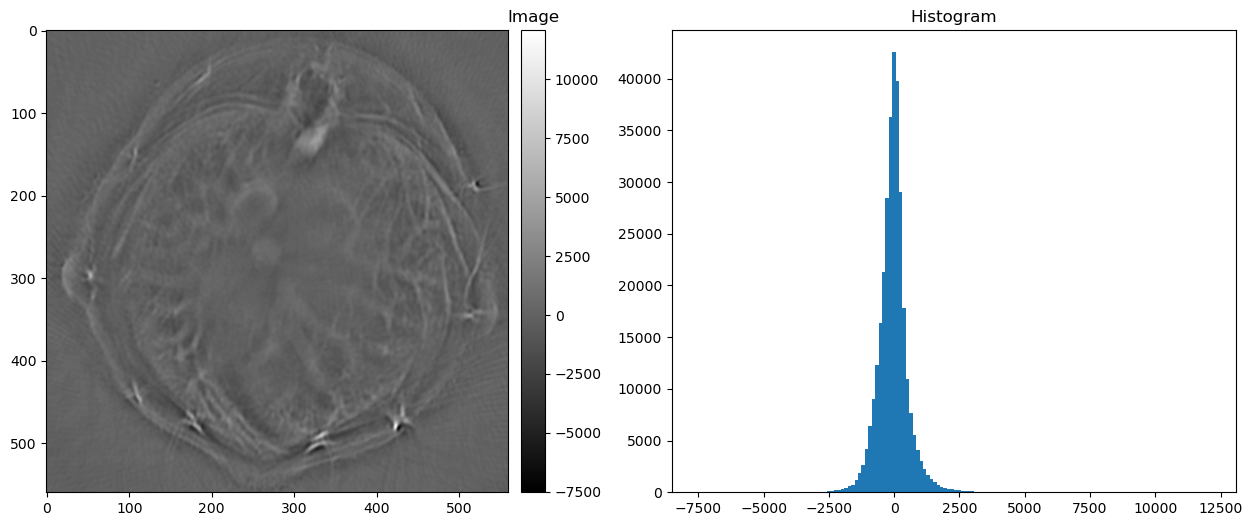

In [8]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(1,2,1)
plt.imshow(baseline, cmap='gray')
cax = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.015, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.title('Image', fontsize=12)

ax2 = plt.subplot(1,2,2)
plt.hist(baseline.ravel(), bins=150)
plt.title('Histogram', fontsize=12)

### WienerNet

In [9]:
def get_water_SoS(t):
    """Calculate the speed of sound of water at temperature `t` in Celsius."""
    a = [1.402385e3, 5.038813, -5.799136e-2, 3.287156e-4, -1.398845e-6, 2.787860e-9]
    SoS = 0
    for i in range(len(a)):
        SoS += a[i] * t**i
    return SoS

R = 11.25e-3 # Radius to center [m].
l = 3.2e-3 # Patch size [m].
T = 31.0 # Temperature of water [C].
v0 = get_water_SoS(T)
v1 = 1635.6 # Background SoS & SoS in tissue [m/s].
print(v0, v1)

1511.439223811262 1635.6


In [10]:
def get_delays(R, v0, v1, n_delays, mode='linear'):
    if mode == 'linear':
        return np.linspace(0, (1-v0/v1) * R, n_delays)
    elif mode == 'quadric':
        return (1-v0/v1) * R * np.sqrt(np.linspace(0,1,n_delays))
    else:
        raise NotImplementedError
    
n_delays = 8
delays = get_delays(R, v0, v1, n_delays, 'linear')
print(delays)

recons = []
for d_delay in delays:
    recon = delay_and_sum(R_ring=0.05,
                          T_sample=1/(40e6), 
                          V_sound=v0,
                          Sinogram=sinogram_deconv[:,46:],
                          ImageX=kgrid.x_vec[:],
                          ImageY=kgrid.y_vec[:],
                          d_delay=d_delay)
    recons.append(recon)

[0.         0.00032278 0.00045648 0.00055908 0.00064557 0.00072177
 0.00079065 0.000854  ]


In [11]:
recons = np.array(recons)
x_c, y_c = center(recons[3])
recons = recons[:,-20+x_c-img_size//2:-20+x_c+img_size//2, y_c-img_size//2:y_c+img_size//2]

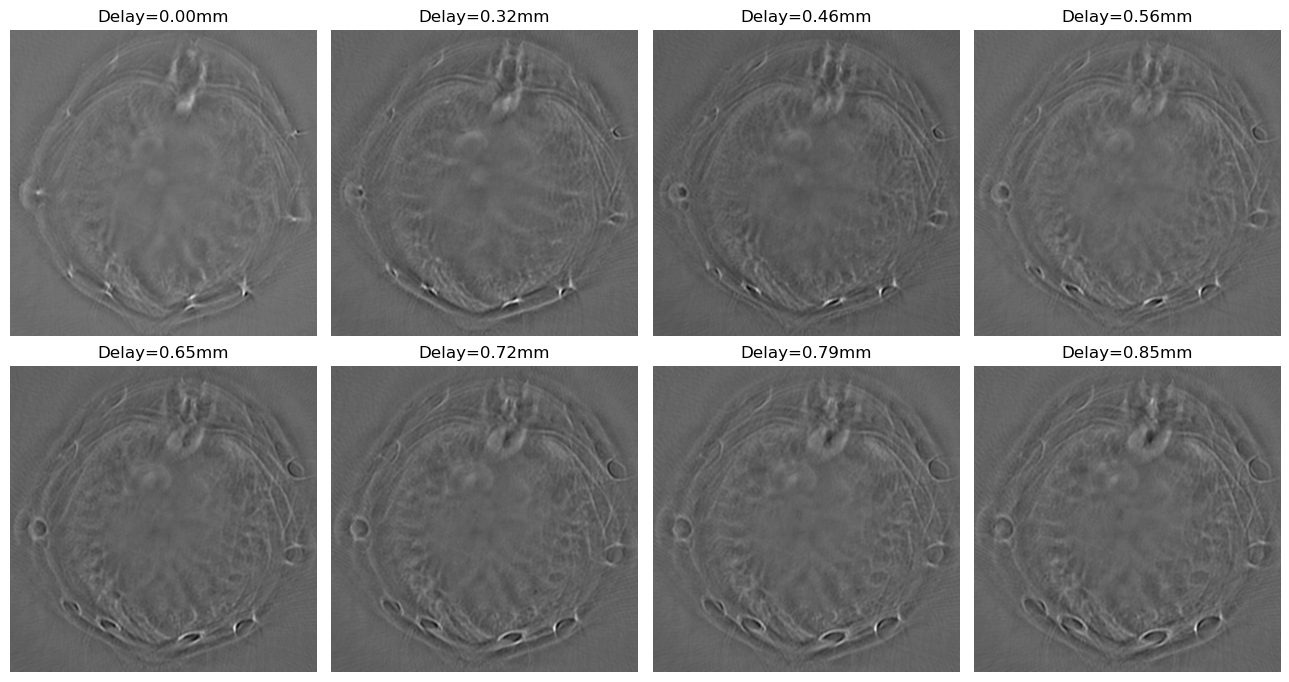

In [12]:
plt.figure(figsize=(13, 7))
for idx, d_delay in enumerate(delays):
    ax1 = plt.subplot(2,4,idx+1)
    plt.imshow(recons[idx,:,:], cmap='gray')
    plt.title('Delay={:.2f}mm'.format(d_delay*1e3), fontsize=12)
    plt.axis('off')
plt.tight_layout()

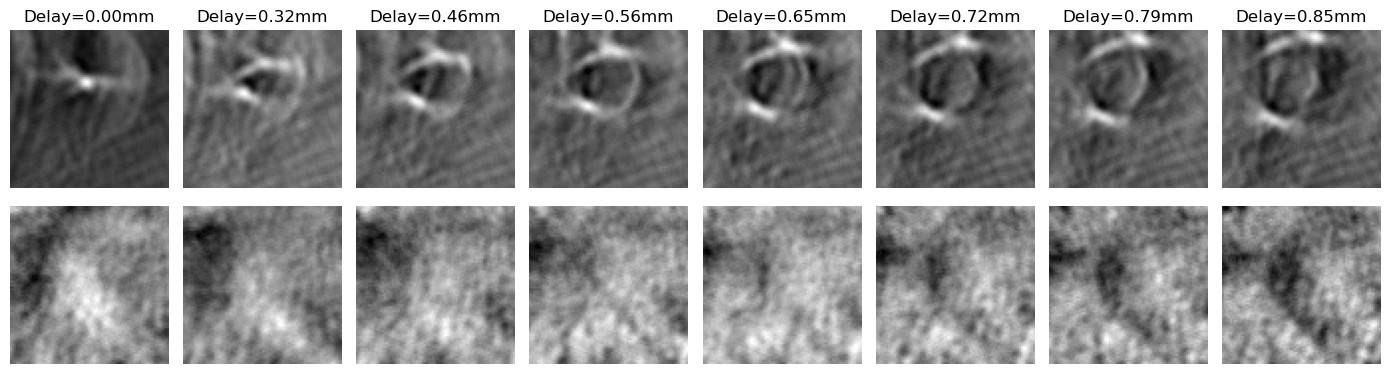

In [13]:
plt.figure(figsize=(14, 4))
for idx, d_delay in enumerate(delays):
    x, y = 320, 480
    plt.subplot(2,8,idx+1)
    plt.imshow(recons[idx,x:x+80,y:y+80], cmap='gray')
    plt.title('Delay={:.2f}mm'.format(d_delay*1e3), fontsize=12)
    plt.axis('off')
    
    x, y = 280, 260
    plt.subplot(2,8,idx+9)
    plt.imshow(recons[idx,x:x+80,y:y+80], cmap='gray')
    plt.axis('off')
plt.tight_layout()

### Wiener Deconvolution

In [14]:
obs_full = recons[3]
obss = []
for i in range(13):
    for j in range(13):
        obs = torch.Tensor(obs_full[40*i:40*i+80, 40*j:40*j+80])
        obss.append(obs)

In [15]:
l = 3.2e-3        
psfs = []
for i in range(13):
    for j in range(13):
        x, y = (j-6)*l / 2, (6-i)*l / 2
        r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
        w_real = wavefront_real(R, torch.tensor(r), torch.tensor(phi), v0, v1)
        k2D, theta2D = get_fourier_coord(n_points=80, l=l, device='cpu')
        psf = []
        for id, delay in enumerate(delays):
            psf.append(PSF(theta2D, k2D, w_real, delay))
        psfs.append(torch.stack(psf, dim=0))

In [16]:
ncs = [32, 16, 8]
rec_fulls = []
pretrained_epochs = [70, 117, 166] # MultiScale
loss = 'MultiScale' # 'MSE'
for nc, pretrained_epoch in zip(ncs, pretrained_epochs):
    model = WienerNet(nc=[nc, nc*2, nc*4, nc*8])
    model.to(device)
    pretrained_file = os.path.join('../saved_models_Mice/', f'WienerNet_{nc}channels_{loss}_{pretrained_epoch}epochs.pth')
    model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {pretrained_file}.')
    model.eval()
    
    rec_full, weights = np.zeros_like(recons[3]), np.zeros_like(recons[3])
    for i in range(13):
        for j in range(13):
            obs, psf = obss[i*13+j], psfs[i*13+j]
            mean = obs.abs().mean()
            obs, psf = obs.unsqueeze(0).to(device), psf.to(device)
            with torch.no_grad():
                rec = model(obs/mean, psf) * mean
            rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
            rec_full[40*i:40*i+80, 40*j:40*j+80] += rec
            weights[40*i:40*i+80, 40*j:40*j+80] += 1
    rec_fulls.append(rec_full/weights)

Successfully loaded in ../saved_models_Mice/WienerNet_32channels_MultiScale_70epochs.pth.
Successfully loaded in ../saved_models_Mice/WienerNet_16channels_MultiScale_117epochs.pth.
Successfully loaded in ../saved_models_Mice/WienerNet_8channels_MultiScale_166epochs.pth.


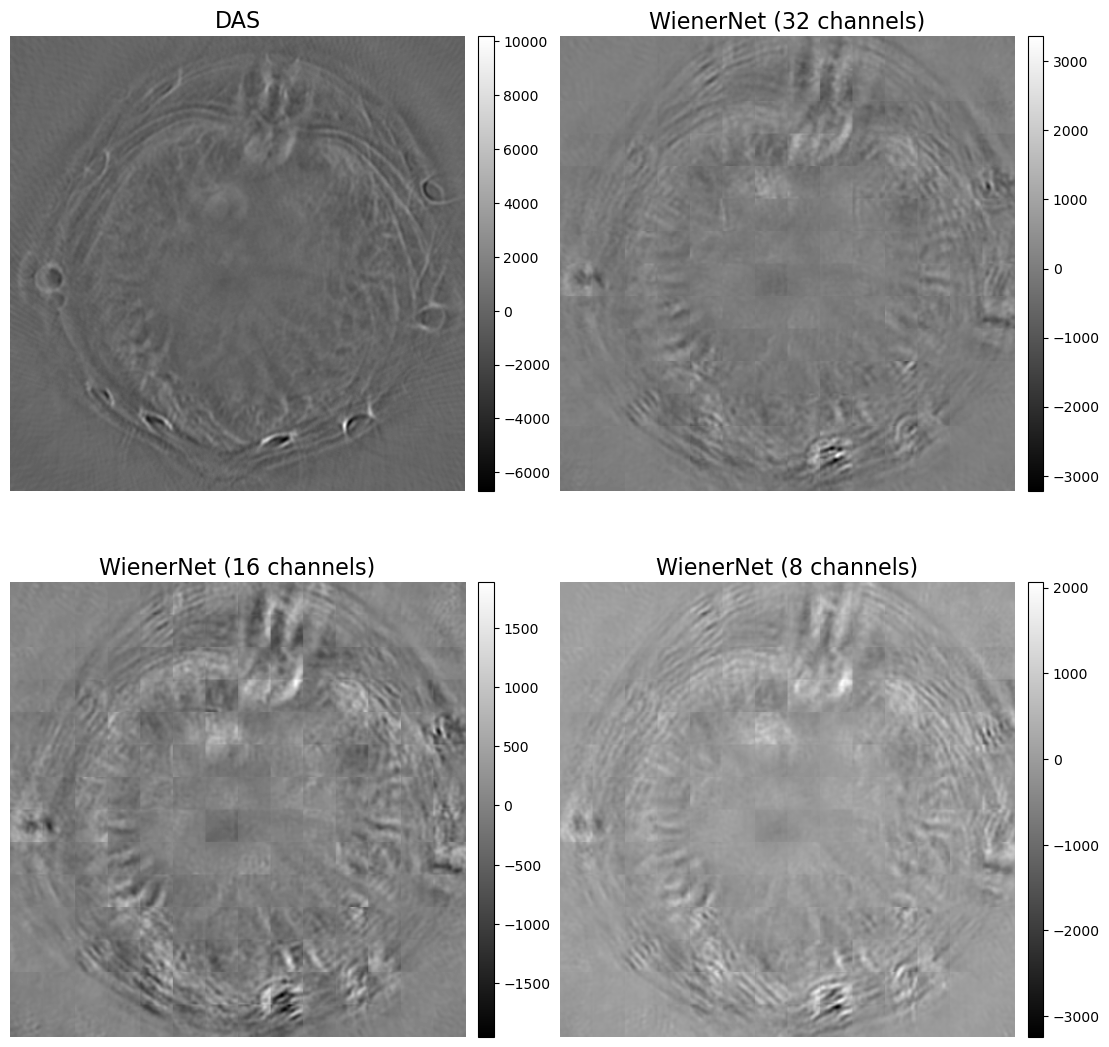

In [17]:
fig = plt.figure(figsize=(13, 13))

ax2 = plt.subplot(2,2,1)
plt.imshow(recons[3], cmap='gray')
plt.title('DAS', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.012, ax2.get_position().height])
cb = plt.colorbar(cax=cax)

ax4 = plt.subplot(2,2,2)
plt.imshow(rec_fulls[0], cmap='gray')
plt.title(f'WienerNet ({ncs[0]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax4.get_position().x1+0.01, ax4.get_position().y0, 0.012, ax4.get_position().height])
cb = plt.colorbar(cax=cax)

ax5 = plt.subplot(2,2,3)
plt.imshow(rec_fulls[1], cmap='gray')
plt.title(f'WienerNet ({ncs[1]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax5.get_position().x1+0.01, ax5.get_position().y0, 0.012, ax5.get_position().height])
cb = plt.colorbar(cax=cax)

ax6 = plt.subplot(2,2,4)
plt.imshow(rec_fulls[2], cmap='gray')
plt.title(f'WienerNet ({ncs[2]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax6.get_position().x1+0.01, ax6.get_position().y0, 0.012, ax6.get_position().height])
cb = plt.colorbar(cax=cax)

# plt.tight_layout()